# Basic implementation of MCTS to Classifier Chains

---
Importing modules to generate data

In [1]:
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split

### Generate some data

In [40]:
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split

n_samples = 10000
n_features = 10
n_classes = 6
n_labels = 2
random_state = 0

X, Y = make_multilabel_classification(
    n_samples = n_samples,
    n_features = n_features,
    n_classes = n_classes,
    n_labels = n_labels,
    random_state = random_state)

test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

In [41]:
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression

solver = "liblinear"
base = LogisticRegression(solver=solver)
chain = ClassifierChain(base)

chain = chain.fit(X_train,Y_train)

# Monte Carlo Tree Search Pseudocode:

> function MonteCarloTreeSearch(root) 
>>     while time_budget_not_exceeded:
>>         node_to_expand = selectNodeToExpand(root)
>>         simulation_result = simulateRandomPlayout(node_to_expand)
>>         backpropagate(simulation_result, node_to_expand)
>>     return bestChild(root)

## Below is a class that implements the constraints imposed.

# In MCTS, many alogirhtms are needed. We implement some below

In [42]:
from mcts_inference.mcts import MCTS, best_child, get_reward, simulate, back_prog, select, eps_greedy, randmax

In [38]:
M = 10
for i in range(M):
    print(f"MCTS Pred:{MCTS(chain,X_test[i])}, ClassifierChain Pred:{chain.predict(X_test[i].reshape(1,-1))[0]} vs True:{Y_test[i]}")

MCTS Pred:[0, 1, 1], ClassifierChain Pred:[0. 1. 1.] vs True:[0 1 1]
MCTS Pred:[0, 0, 0], ClassifierChain Pred:[0. 0. 0.] vs True:[0 0 0]
MCTS Pred:[1, 1, 0], ClassifierChain Pred:[1. 1. 0.] vs True:[0 1 0]
MCTS Pred:[0, 1, 0], ClassifierChain Pred:[0. 1. 0.] vs True:[1 1 1]
MCTS Pred:[1, 1, 1], ClassifierChain Pred:[1. 1. 1.] vs True:[1 0 0]
MCTS Pred:[0, 0, 1], ClassifierChain Pred:[0. 0. 1.] vs True:[0 0 0]
MCTS Pred:[1, 1, 1], ClassifierChain Pred:[1. 1. 1.] vs True:[1 1 1]
MCTS Pred:[1, 0, 0], ClassifierChain Pred:[1. 0. 0.] vs True:[1 0 0]
MCTS Pred:[1, 1, 1], ClassifierChain Pred:[1. 1. 1.] vs True:[1 0 0]
MCTS Pred:[1, 1, 1], ClassifierChain Pred:[1. 1. 1.] vs True:[1 1 1]


In [43]:
MCTS(chain,X_test[0],visualize=True);

# Implementation seems fine, now let's compare accuracies

## We compare different things:
* How different are predictions from the base model
* The hamming loss
* The 0/1 loss
* Accuracy for different times

In [37]:
from tqdm import trange
from sklearn.metrics import hamming_loss, zero_one_loss

secs = 1. # 0.5 Second per inference to test
M = min(100,len(Y_test))

y_mcts = []
y_chain = chain.predict(X_test[:M])

for i in trange(M, desc=f"MCTS Inference Constraint={secs}s", unit="it",colour="green"):
    y_mcts.append(MCTS(chain,X_test[i],secs=secs))
    

y_mcts = np.array(y_mcts)

MCTS Inference Constraint=0.01s: 100%|████████| 100/100 [00:01<00:00, 98.30it/s]


In [29]:
from sklearn.metrics import hamming_loss, zero_one_loss

print(f"MCTS  vs TRUE : Hamming={hamming_loss(y_mcts,Y_test[:M]):.4f}, ZeroOne={zero_one_loss(y_mcts,Y_test[:M]):.4f}")
print(f"CHAIN vs TRUE : Hamming={hamming_loss(y_chain,Y_test[:M]):.4f}, ZeroOne={zero_one_loss(y_chain,Y_test[:M]):.4f}")
print(f"MCTS  vs CHAIN: Hamming={hamming_loss(y_chain,y_mcts):.4f}, ZeroOne={zero_one_loss(y_chain,y_mcts):.4f}")

MCTS  vs TRUE : Hamming=0.2467, ZeroOne=0.5000
CHAIN vs TRUE : Hamming=0.2533, ZeroOne=0.5400
MCTS  vs CHAIN: Hamming=0.1133, ZeroOne=0.2500


In [44]:
from sklearn.metrics import hamming_loss, zero_one_loss

secs_lis = [0.1, 0.5, 1.] #  2.]
M = min(100,len(Y_test))

hl_mt = []
hl_ct = []
hl_mc = []

zo_mt = []
zo_ct = []
zo_mc = []

y_chain = chain.predict(X_test[:M])
for secs in secs_lis:
#     continue
    y_mcts = []

    for i in trange(M, desc=f"MCTS Inference Constraint={secs}s", unit="it",colour="green"):
        y_mcts.append(MCTS(chain,X_test[i],secs=secs))

    y_mcts = np.array(y_mcts)
    
    hl_mt.append(hamming_loss(y_mcts,Y_test[:M]))
    hl_ct.append(hamming_loss(y_chain,Y_test[:M]))
    hl_mc.append(hamming_loss(y_chain,y_mcts))

    zo_mt.append(zero_one_loss(y_mcts,Y_test[:M]))
    zo_ct.append(zero_one_loss(y_chain,Y_test[:M]))
    zo_mc.append(zero_one_loss(y_chain,y_mcts))

MCTS Inference Constraint=1.0s: 100%|█████████| 100/100 [01:40<00:00,  1.00s/it]


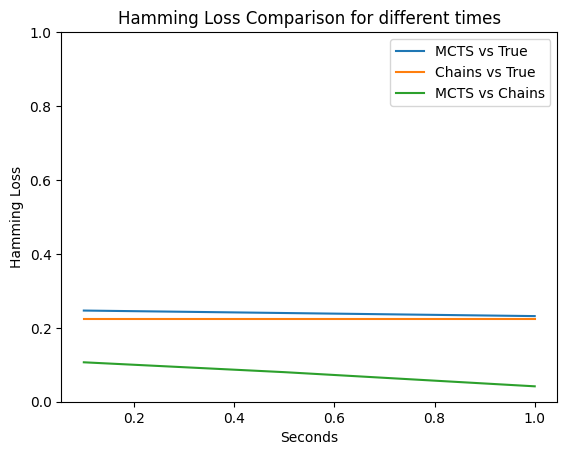

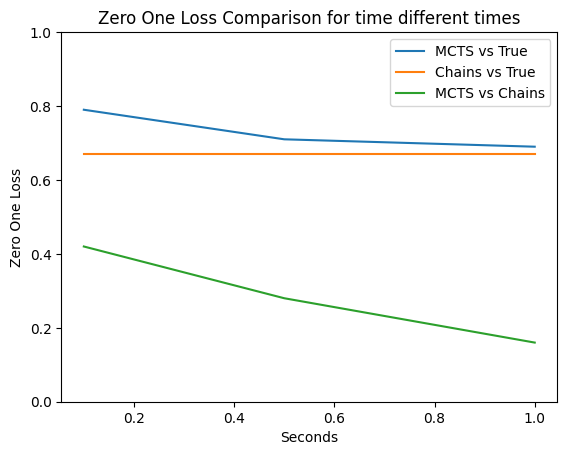

In [45]:
import matplotlib.pyplot as plt

plt.plot(secs_lis,hl_mt,label="MCTS vs True")
plt.plot(secs_lis,hl_ct,label="Chains vs True")
plt.plot(secs_lis,hl_mc,label="MCTS vs Chains")

plt.title("Hamming Loss Comparison for different times")
plt.xlabel("Seconds")
plt.ylim(0,1)
plt.ylabel("Hamming Loss")
plt.legend()
plt.show();

plt.plot(secs_lis,zo_mt,label="MCTS vs True")
plt.plot(secs_lis,zo_ct,label="Chains vs True")
plt.plot(secs_lis,zo_mc,label="MCTS vs Chains")

plt.title("Zero One Loss Comparison for time different times")
plt.xlabel("Seconds")
plt.ylim(0,1)
plt.ylabel("Zero One Loss")
plt.legend()
plt.show();